# AIBS sample selection

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.spatial
#import nipy
#import nibabel as nib
import math
import feather
from scipy.stats import t, spearmanr, norm, wilcoxon, mannwhitneyu, ttest_ind
import matplotlib
from matplotlib.pyplot import scatter
from statsmodels.sandbox.stats.multicomp import multipletests
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import svd, eig


In [2]:
#some useful functions

#3d scatter plots (for point clouds)
def quickPlot3DBrain(X,Y,Z, cv='b', angle=[0,90]):
    fig = matplotlib.pyplot.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, s=2, c=cv)
    ax.view_init(angle[0], angle[1])
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.grid(False)
    
    matplotlib.pyplot.show()

#find substrings
def FindAnySubstring(mystr, sublist):
    for s in sublist:
        if mystr.find(s) > -1:
            return True
    return False

#small function to derive the number of genes being tagged
def GetUniqueGene(mystr):
    tok = mystr.strip().split(' ')
    tok_set = set(tok)
    return(list(tok_set))

def CheckUniqueGene(mystr):
    genes = GetUniqueGene(mystr)
    return len(genes) == 1


In [3]:
#some options
#Download the data from http://human.brain-map.org/static/download
AIBS_path='../AllenData'
donors=['H0351_1009','H0351_1012', 'H0351_1015', 'H0351_1016', 'H0351_2001', 'H0351_2002']
max_probe_dist=3

In [4]:
##read list of mni_coordinates
#they are obtained from:
#github 
mni_coord = pd.read_csv('corrected_mni_coordinates.csv')
mni_coord.head()

,well_id,corrected_mni_x,corrected_mni_y,corrected_mni_z
0,126439333,-13.467693,2.255686,3.432523
1,126432538,-53.603259,-8.120055,0.868643
2,126435762,-16.288739,-34.198856,-19.944686
3,126439285,-17.820212,3.595613,-32.872868
4,126435744,-23.726456,-25.139000,-16.692841


In [5]:
sample_info = pd.read_csv("../data/GIF_labels_mod_sample_info_newmni.csv")

In [6]:
sample_info.head()

,well_id,structure_id,slab_num,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,corrected_mni_x,corrected_mni_y,corrected_mni_z,sampleID,probe2label,probe2dist
0,10964,4023,2,CX,SFG-m,"superior frontal gyrus, left, medial bank of g...",1266467,96,55,47,-5.0,44.0,54.0,-4.456913,42.626309,53.306473,H0351_1009,192,0.000000
1,10965,4039,2,CX,trIFG,"inferior frontal gyrus, triangular part, left",1266555,128,113,44,-37.0,47.0,-4.0,-37.014483,42.918867,-0.301717,H0351_1009,206,1.000000
2,10966,4051,3,CX,MOrG,"medial orbital gyrus, left",1265851,100,137,59,-9.0,32.0,-28.0,-9.535526,30.015430,-24.276204,H0351_1009,148,0.000000
3,10972,4224,2,CX,CgGf-i,"cingulate gyrus, frontal part, left, inferior ...",1266689,96,110,46,-5.0,45.0,-1.0,-5.445986,42.277137,1.581663,H0351_1009,102,0.000000
4,10973,4024,3,CX,SFG-l,"superior frontal gyrus, left, lateral bank of ...",1265853,114,63,62,-23.0,29.0,46.0,-18.855630,25.569178,43.817038,H0351_1009,192,1.414214


In [7]:
#restrict samples:
#some helper variables (note: sample info was annoated with GIF labels)
#all labels
al = list(set(sample_info.probe2label))
al.sort()

#cortical labels
cor_lab = list(pd.Series(al)[pd.Series(al) > 100])
#left hemisphere
lcor_lab = np.arange(102,208,2)
#right hemisphere
rcor_lab = np.arange(101,207,2)


In [8]:
#annotated with left cortex by GIF
lh_cort_idx = sample_info.apply(lambda x: x["probe2label"] in lcor_lab, axis=1)
#slab type == "CX"
cx_idx = sample_info.slab_type == "CX"
#max 2 mm away from label
pdist_idx = sample_info.probe2dist <= max_probe_dist

array([[<AxesSubplot:title={'center':'probe2dist'}>]], dtype=object)

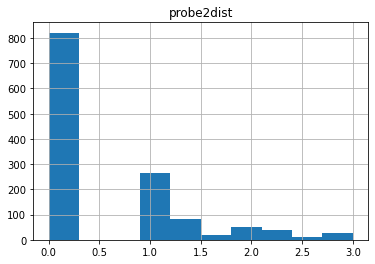

In [9]:
sample_info[lh_cort_idx & cx_idx & pdist_idx].hist("probe2dist")

In [10]:
sample_info_v2 = sample_info[lh_cort_idx & cx_idx & pdist_idx]

In [11]:
#set(sample_info_v2.structure_name.values)

In [12]:
#remove structure names containing following strings
rm_names=["CA1 field","CA2 field","CA3 field","CA4 field","amygdalohippocampal transition zone","basal nucleus of meynert",
          "basolateral nucleus","claustrum","corpus callosum","cortico-medial group","dentate gyrus","lateral nucleus",
          "nucleus accumbens","nucleus of the diagonal band","pineal gland","piriform cortex","putamen","septal nuclei",
          "subiculum","substantia nigra","tail of caudate nucleus","right"]
rm_names_idx = sample_info_v2.apply(lambda x: FindAnySubstring(x.structure_name, rm_names), axis=1)
rm_names_idx_plot = sample_info.apply(lambda x: FindAnySubstring(x.structure_name, rm_names), axis=1)


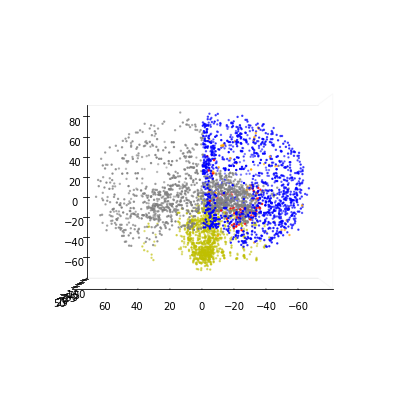

In [13]:
#plot for visual inspection
my_col = pd.Series(['grey'] * sample_info.shape[0])
my_col[~lh_cort_idx] = 'grey'
my_col[~cx_idx ] = 'y'
my_col[~pdist_idx & lh_cort_idx] = 'orange'
my_col[rm_names_idx_plot & lh_cort_idx & cx_idx & pdist_idx] = 'r'
my_col[~rm_names_idx_plot & lh_cort_idx & cx_idx & pdist_idx] = 'b'
quickPlot3DBrain(sample_info.corrected_mni_x, sample_info.corrected_mni_y, sample_info.corrected_mni_z, cv=my_col)

In [14]:
sample_info_v3 = sample_info_v2[~rm_names_idx]

In [15]:
sample_info_v3.shape

(1248, 19)

In [16]:
#store well_ids
sample_info_v3.well_id.to_csv("../data/AIBS_well_ids.csv", index=False)

In [17]:
sample_info_v3.to_csv("../data/MS_Parcellation_AIBS.csv")

In [18]:
sample_info_v3.head()

,well_id,structure_id,slab_num,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,corrected_mni_x,corrected_mni_y,corrected_mni_z,sampleID,probe2label,probe2dist
0,10964,4023,2,CX,SFG-m,"superior frontal gyrus, left, medial bank of g...",1266467,96,55,47,-5.0,44.0,54.0,-4.456913,42.626309,53.306473,H0351_1009,192,0.000000
1,10965,4039,2,CX,trIFG,"inferior frontal gyrus, triangular part, left",1266555,128,113,44,-37.0,47.0,-4.0,-37.014483,42.918867,-0.301717,H0351_1009,206,1.000000
2,10966,4051,3,CX,MOrG,"medial orbital gyrus, left",1265851,100,137,59,-9.0,32.0,-28.0,-9.535526,30.015430,-24.276204,H0351_1009,148,0.000000
3,10972,4224,2,CX,CgGf-i,"cingulate gyrus, frontal part, left, inferior ...",1266689,96,110,46,-5.0,45.0,-1.0,-5.445986,42.277137,1.581663,H0351_1009,102,0.000000
4,10973,4024,3,CX,SFG-l,"superior frontal gyrus, left, lateral bank of ...",1265853,114,63,62,-23.0,29.0,46.0,-18.855630,25.569178,43.817038,H0351_1009,192,1.414214
